In [1]:
# Cell 0: Install required libraries
!conda install -c bioconda muscle -y
!pip install biopython pyrosetta-distributed numpy pandas matplotlib scipy py3dmol



Channels:
 - bioconda
 - r
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [3]:
# Diagnostic Cell: Check py3dmol installation
import sys
import subprocess

print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

print("\nInstalled packages:")
!pip list

print("\npy3dmol installation details:")
!pip show py3dmol

print("\npy3dmol in sys.path:")
print(any('py3dmol' in p for p in sys.path))

print("\nAttempt to find py3dmol:")
!python -c "import py3dmol; print(py3dmol.__file__)"

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
Python executable: /opt/anaconda3/envs/rosetta/bin/python

Installed packages:
Package                       Version
----------------------------- --------------------------
accelerate                    0.33.0
aiohappyeyeballs              2.3.5
aiohttp                       3.10.3
aiosignal                     1.3.1
alabaster                     0.7.16
alembic                       1.13.2
annotated-types               0.7.0
antlr4-python3-runtime        4.9.3
anyio                         4.4.0
appdirs                       1.4.4
appnope                       0.1.4
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.1
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.2.0
awesome-slugify               1.6.5
Babel                         2.14.0


In [4]:
!pip uninstall py3Dmol -y
!pip install py3Dmol

# Try importing again
import py3Dmol

print("Successfully imported py3Dmol")
print(f"py3Dmol version: {py3Dmol.__version__}")

Found existing installation: py3Dmol 2.4.0
Uninstalling py3Dmol-2.4.0:
  Successfully uninstalled py3Dmol-2.4.0
  Using cached py3Dmol-2.4.0-py2.py3-none-any.whl.metadata (1.9 kB)
Using cached py3Dmol-2.4.0-py2.py3-none-any.whl (7.0 kB)
Successfully imported py3Dmol
py3Dmol version: 2.4.0


In [5]:
# Cell 1: Import required libraries
import os
from Bio import PDB, AlignIO, SeqIO
from Bio.Align.Applications import MuscleCommandline
import pyrosetta
import pymol
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import py3Dmol

# Initialize PyRosetta
pyrosetta.init()

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.m1 r384 2024.24+release.ca096dac4f ca096dac4f43ee5ee195

In [6]:
# Cell 3: Download PDB structures
def download_pdb(pdb_id):
    pdb_list = PDB.PDBList()
    pdb_list.retrieve_pdb_file(pdb_id, pdir='./pdb', file_format='pdb')
    return f"./pdb/pdb{pdb_id.lower()}.ent"

pdb_ids = ['5NKQ', '5A43', '6RB5']
pdb_files = [download_pdb(pdb_id) for pdb_id in pdb_ids]

print("Downloaded PDB files:", pdb_files)

Structure exists: './pdb/pdb5nkq.ent' 
Structure exists: './pdb/pdb5a43.ent' 
Structure exists: './pdb/pdb6rb5.ent' 
Downloaded PDB files: ['./pdb/pdb5nkq.ent', './pdb/pdb5a43.ent', './pdb/pdb6rb5.ent']


In [13]:
import numpy as np
from scipy.spatial.distance import cdist
import pyrosetta
from Bio import PDB
import warnings
from tqdm.notebook import tqdm

# Suppress warnings
warnings.filterwarnings("ignore")

def is_amino_acid(residue):
    return residue.get_id()[0] == ' '  # Standard amino acids have a blank chain identifier

def analyze_structure(pdb_file):
    # Load structure
    parser = PDB.PDBParser(QUIET=True)
    structure = parser.get_structure('protein', pdb_file)
    
    # Initialize PyRosetta
    pyrosetta.init(options="-mute all")
    
    # Load the pose
    pose = pyrosetta.pose_from_pdb(pdb_file)
    sfxn = pyrosetta.get_fa_scorefxn()
    
    # Get coordinates of only amino acid residues
    aa_coords = np.array([atom.coord for residue in structure.get_residues() if is_amino_acid(residue) for atom in residue])
    
    # Create a coarser grid around the protein
    margin = 10  # Angstroms
    min_coords = np.min(aa_coords, axis=0) - margin
    max_coords = np.max(aa_coords, axis=0) + margin
    grid_size = 2.0  # Increased grid size for efficiency
    x, y, z = np.mgrid[min_coords[0]:max_coords[0]:grid_size, 
                       min_coords[1]:max_coords[1]:grid_size, 
                       min_coords[2]:max_coords[2]:grid_size]
    grid_points = np.column_stack((x.ravel(), y.ravel(), z.ravel()))
    
    # Calculate distances to all atoms (in batches to save memory)
    batch_size = 10000
    binding_sites = []
    for i in range(0, len(grid_points), batch_size):
        batch = grid_points[i:i+batch_size]
        distances = cdist(batch, aa_coords)
        min_distance = 3.0  # Angstroms
        max_distance = 8.0  # Angstroms
        binding_sites.extend(batch[(distances.min(axis=1) > min_distance) & (distances.min(axis=1) < max_distance)])
    binding_sites = np.array(binding_sites)
    
    # Map electrostatic surface potential (only for amino acid residues)
    elec_scores = []
    for i in range(1, pose.total_residue() + 1):
        if pose.residue(i).is_protein():
            elec_scores.append(sfxn.score_by_scoretype(pose, pyrosetta.rosetta.core.scoring.ScoreType.fa_elec))
        else:
            elec_scores.append(None)  # or some placeholder value
    
    # Locate key residues (amino acid residues close to potential binding sites)
    key_residues = []
    for i, residue in enumerate(pose.residues, 1):
        if residue.is_protein():
            try:
                ca_coord = residue.xyz('CA')
                if cdist([[ca_coord.x, ca_coord.y, ca_coord.z]], binding_sites).min() < 5.0:
                    key_residues.append(i)
            except RuntimeError:
                continue  # Skip if there's an issue with the residue
    
    return {
        'binding_sites': binding_sites,
        'electrostatics': elec_scores,
        'key_residues': key_residues
    }


In [14]:
# Cell 5: Analyze structures with progress bar
results = {}
for pdb_id, pdb_file in tqdm(list(zip(pdb_ids, pdb_files)), desc="Analyzing structures"):
    results[pdb_id] = analyze_structure(pdb_file)
    
print("Analysis complete. Results stored in 'results' dictionary.")

# Print some basic results
for pdb_id in pdb_ids:
    print(f"\nResults for {pdb_id}:")
    print(f"  Number of potential binding sites: {len(results[pdb_id]['binding_sites'])}")
    print(f"  Number of key residues: {len(results[pdb_id]['key_residues'])}")
    print(f"  First few key residues: {results[pdb_id]['key_residues'][:5]}")

Analyzing structures:   0%|          | 0/3 [00:00<?, ?it/s]

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python39.m1 2024.24+release.ca096dac4f43ee5ee195f87f3703a520fcf60cf9 2024-06-14T16:57:57] retrieved from: http://www.pyrosetta.org
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python39.m1 r384 2024.24+release.ca096dac4f ca096dac4f43ee5ee195

In [15]:
# Cell 6: Import additional required libraries
import matplotlib.pyplot as plt
from Bio import AlignIO, SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.PDB import PDBParser, Selection
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import cKDTree
import seaborn as sns
from sklearn.cluster import DBSCAN
import py3Dmol


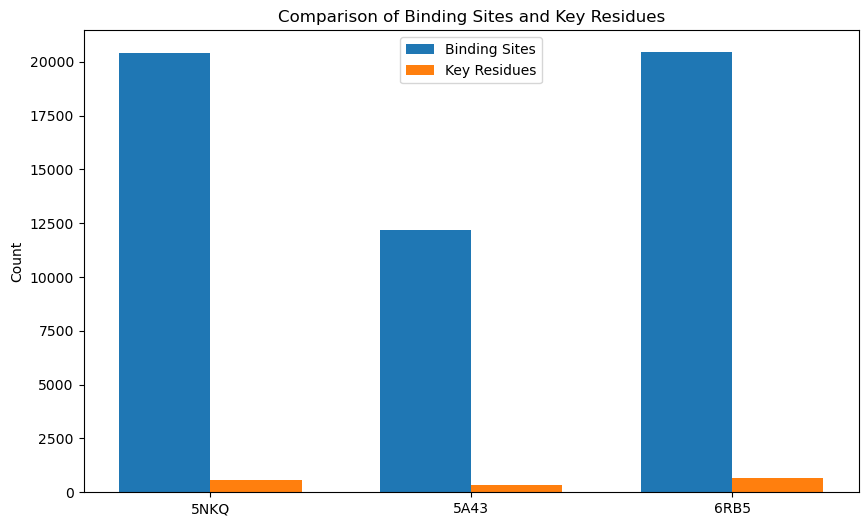

In [16]:
# Cell 7: Comparative Analysis
def compare_structures(results):
    fig, ax = plt.subplots(figsize=(10, 6))
    structures = list(results.keys())
    binding_sites = [len(results[s]['binding_sites']) for s in structures]
    key_residues = [len(results[s]['key_residues']) for s in structures]
    
    x = range(len(structures))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], binding_sites, width, label='Binding Sites')
    ax.bar([i + width/2 for i in x], key_residues, width, label='Key Residues')
    
    ax.set_ylabel('Count')
    ax.set_title('Comparison of Binding Sites and Key Residues')
    ax.set_xticks(x)
    ax.set_xticklabels(structures)
    ax.legend()
    
    plt.show()

compare_structures(results)


In [17]:
# Cell 8: Binding Site Clustering
def cluster_binding_sites(binding_sites, eps=5, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(binding_sites)
    return clustering.labels_

for pdb_id in results:
    labels = cluster_binding_sites(results[pdb_id]['binding_sites'])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"{pdb_id}: {n_clusters} distinct binding site clusters")


5NKQ: 3 distinct binding site clusters
5A43: 1 distinct binding site clusters
6RB5: 1 distinct binding site clusters


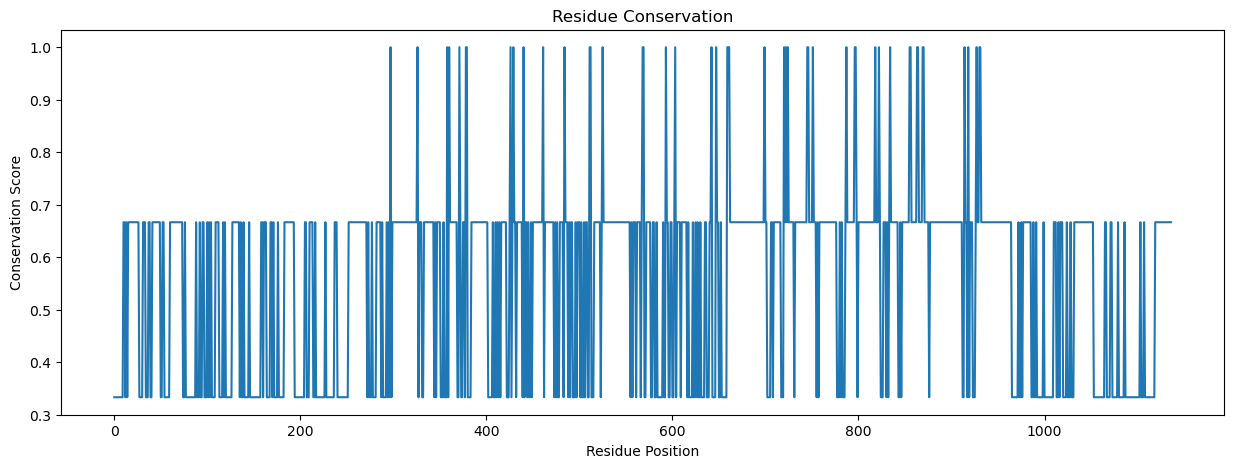

In [19]:
# Cell 9: Residue Conservation
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import protein_letters_3to1
from Bio.Align.Applications import ClustalOmegaCommandline

def perform_msa(pdb_ids):
    sequences = []
    for pdb_id in pdb_ids:
        parser = PDBParser(QUIET=True)
        structure = parser.get_structure('protein', f"./pdb/pdb{pdb_id.lower()}.ent")
        seq = ''.join([protein_letters_3to1.get(residue.resname, 'X') 
                       for residue in structure.get_residues() 
                       if residue.id[0] == ' '])  # Only standard amino acids
        sequences.append(SeqIO.SeqRecord(Seq(seq), id=pdb_id))
    
    SeqIO.write(sequences, "sequences.fasta", "fasta")
    
    clustalomega_cline = ClustalOmegaCommandline(infile="sequences.fasta", outfile="aligned.fasta", verbose=True, auto=True)
    clustalomega_cline()
    
    return AlignIO.read("aligned.fasta", "fasta")

# Use the function
alignment = perform_msa(results.keys())

def calculate_conservation(alignment):
    n_seqs = len(alignment)
    conservation = []
    for i in range(alignment.get_alignment_length()):
        column = alignment[:, i]
        most_common = max(set(column), key=column.count)
        conservation.append(column.count(most_common) / n_seqs)
    return conservation

conservation = calculate_conservation(alignment)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(conservation)
plt.title('Residue Conservation')
plt.xlabel('Residue Position')
plt.ylabel('Conservation Score')
plt.show()

In [25]:
#Cell #10
from pymol import cmd
import os
import numpy as np

def visualize_structure_pymol(pdb_id, binding_sites, key_residues):
    # Clear PyMOL
    cmd.delete('all')
    
    # Load the PDB file
    try:
        cmd.fetch(pdb_id, async_=0)
    except:
        print(f"Failed to fetch {pdb_id}. Make sure you have an internet connection.")
        return
    
    # Set style to cartoon and color by chain
    cmd.show_as('cartoon', pdb_id)
    cmd.util.cbc(pdb_id)  # Color by chain
    
    # Highlight binding sites as spheres
    for i, site in enumerate(binding_sites[:100]):  # Limit to 100 binding sites for performance
        # Convert numpy array to tuple if necessary
        if isinstance(site, np.ndarray):
            site = tuple(site)
        cmd.pseudoatom(f"site_{i}", pos=site, color='red')
        cmd.show("spheres", f"site_{i}")
        cmd.set('sphere_transparency', 0.5, f"site_{i}")
    
    # Highlight key residues
    if key_residues:
        cmd.select("key_residues", f"resi {'+'.join(map(str, key_residues))}")
        cmd.color("yellow", "key_residues")
        cmd.show("sticks", "key_residues")
    
    # Zoom to structure
    cmd.zoom()
    
    # Save the image as a PNG file
    output_path = os.path.abspath(f"{pdb_id}_visualization.png")
    cmd.png(output_path, dpi=300, ray=1)
    print(f"Visualization for {pdb_id} saved as {output_path}")
    
    # Clear selection to avoid cluttering
    cmd.deselect()

# Visualize each structure
for pdb_id in results:
    print(f"Visualizing {pdb_id}...")
    binding_sites = results[pdb_id]['binding_sites']
    key_residues = results[pdb_id]['key_residues']
    visualize_structure_pymol(pdb_id, binding_sites, key_residues)
    print(f"Visualization for {pdb_id} complete.\n")

# If using within PyMOL's own Python environment, you can run this script using the PyMOL command line or PyMOL GUI.

Visualizing 5NKQ...
Visualization for 5NKQ saved as /Users/dev/Desktop/InsciBio/Tools/github/5NKQ_visualization.png
Visualization for 5NKQ complete.

Visualizing 5A43...
Visualization for 5A43 saved as /Users/dev/Desktop/InsciBio/Tools/github/5A43_visualization.png
Visualization for 5A43 complete.

Visualizing 6RB5...
Visualization for 6RB5 saved as /Users/dev/Desktop/InsciBio/Tools/github/6RB5_visualization.png
Visualization for 6RB5 complete.



Visualization for 5NKQ:


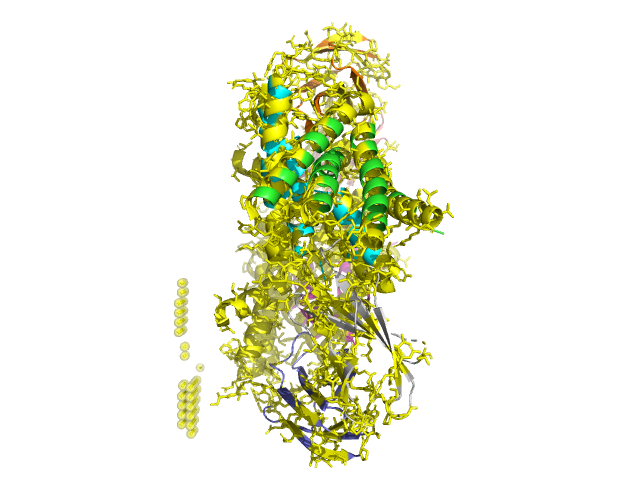



Visualization for 5A43:


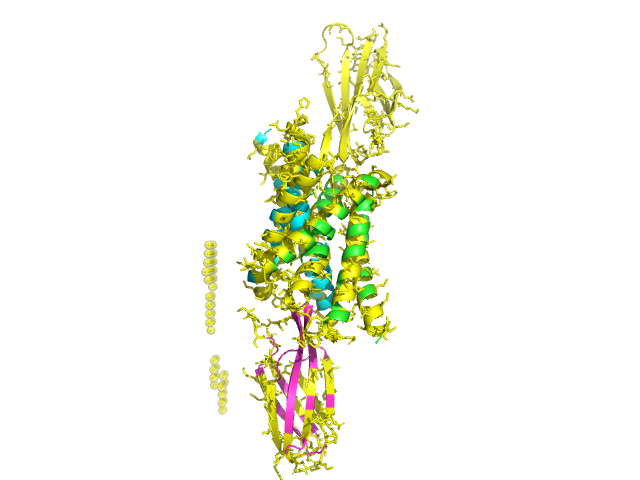



Visualization for 6RB5:


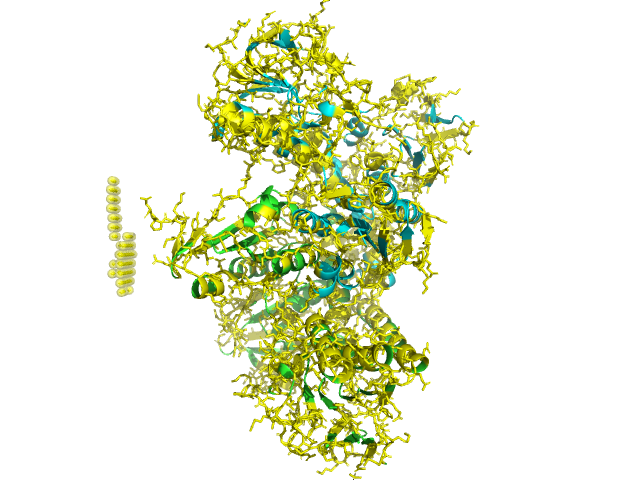

In [26]:
from IPython.display import Image, display
import os

def display_pymol_visualizations(pdb_ids):
    for pdb_id in pdb_ids:
        image_path = f"/Users/dev/Desktop/InsciBio/Tools/github/{pdb_id}_visualization.png"
        if os.path.exists(image_path):
            print(f"Visualization for {pdb_id}:")
            display(Image(filename=image_path, width=800))
            print("\n")
        else:
            print(f"Visualization for {pdb_id} not found at {image_path}")

# Display visualizations for all structures in results
display_pymol_visualizations(results.keys())

Visualizing 5NKQ...
Visualization for 5NKQ saved as 5NKQ_visualization.png


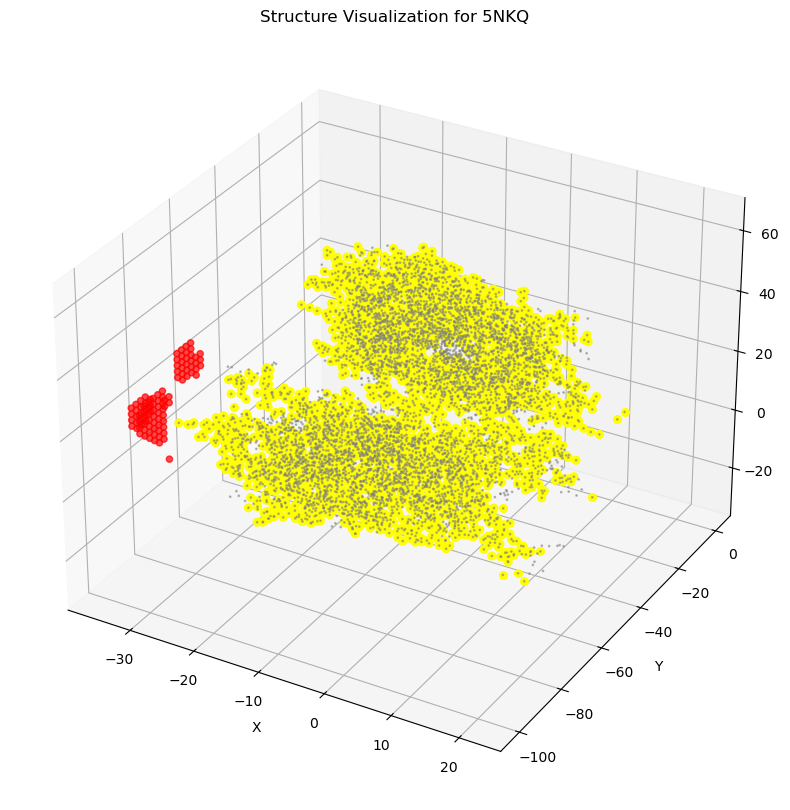

Visualization for 5NKQ complete.

Visualizing 5A43...
Visualization for 5A43 saved as 5A43_visualization.png


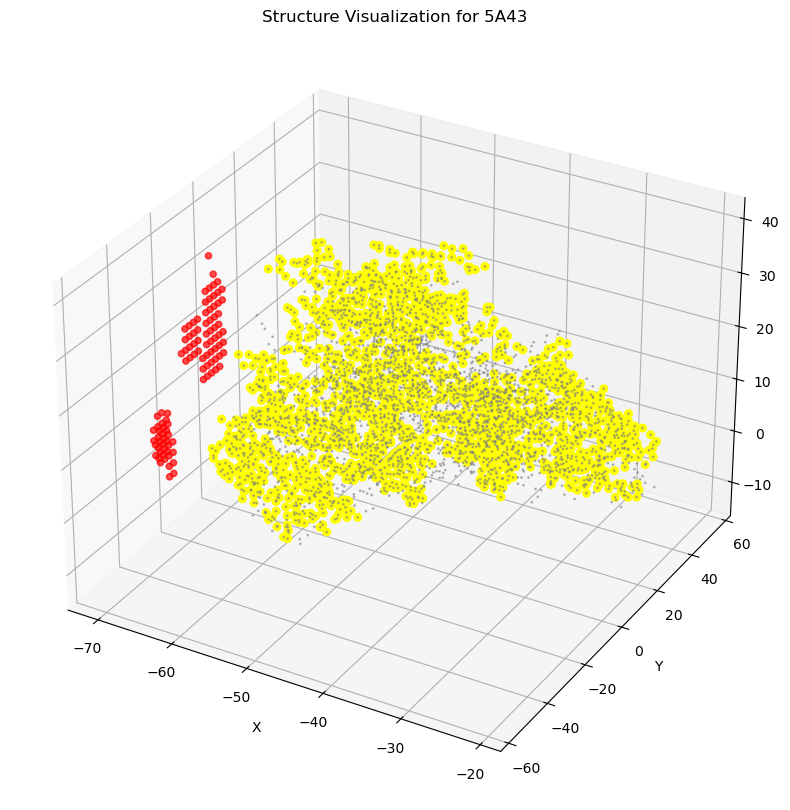

Visualization for 5A43 complete.

Visualizing 6RB5...
Visualization for 6RB5 saved as 6RB5_visualization.png


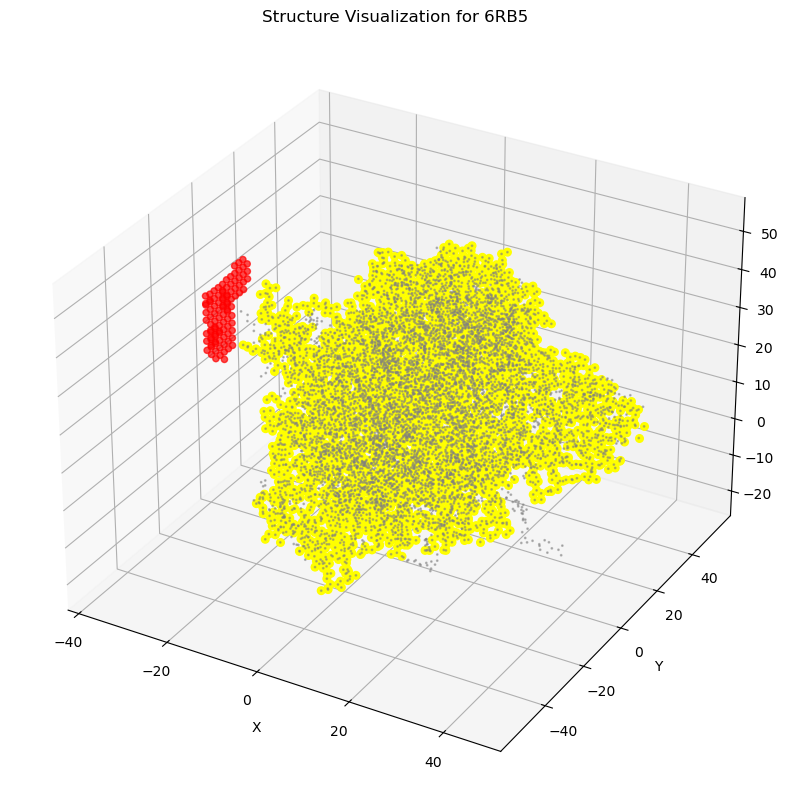

Visualization for 6RB5 complete.



In [22]:
# Cell 12: Matplotlib 3D Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio.PDB import PDBParser
import numpy as np

def visualize_structure(pdb_id, pdb_file, binding_sites, key_residues):
    # Parse the PDB file
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file)
    
    # Extract coordinates
    coords = np.array([atom.coord for atom in structure.get_atoms()])
    
    # Create the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all atoms as small dots
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='gray', s=1, alpha=0.5)
    
    # Plot binding sites
    binding_sites = np.array(binding_sites[:100])  # Limit to 100 sites for performance
    ax.scatter(binding_sites[:, 0], binding_sites[:, 1], binding_sites[:, 2], c='red', s=20, alpha=0.7)
    
    # Highlight key residues
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[1] in key_residues:
                    res_coords = np.array([atom.coord for atom in residue])
                    ax.scatter(res_coords[:, 0], res_coords[:, 1], res_coords[:, 2], c='yellow', s=30, alpha=1)
    
    ax.set_title(f'Structure Visualization for {pdb_id}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Save the plot
    plt.savefig(f"{pdb_id}_visualization.png", dpi=300, bbox_inches='tight')
    print(f"Visualization for {pdb_id} saved as {pdb_id}_visualization.png")
    
    # Display the plot
    plt.show()

# Visualize each structure
for pdb_id in results:
    pdb_file = f"./pdb/pdb{pdb_id.lower()}.ent"
    print(f"Visualizing {pdb_id}...")
    visualize_structure(pdb_id, pdb_file, results[pdb_id]['binding_sites'], results[pdb_id]['key_residues'])
    print(f"Visualization for {pdb_id} complete.\n")

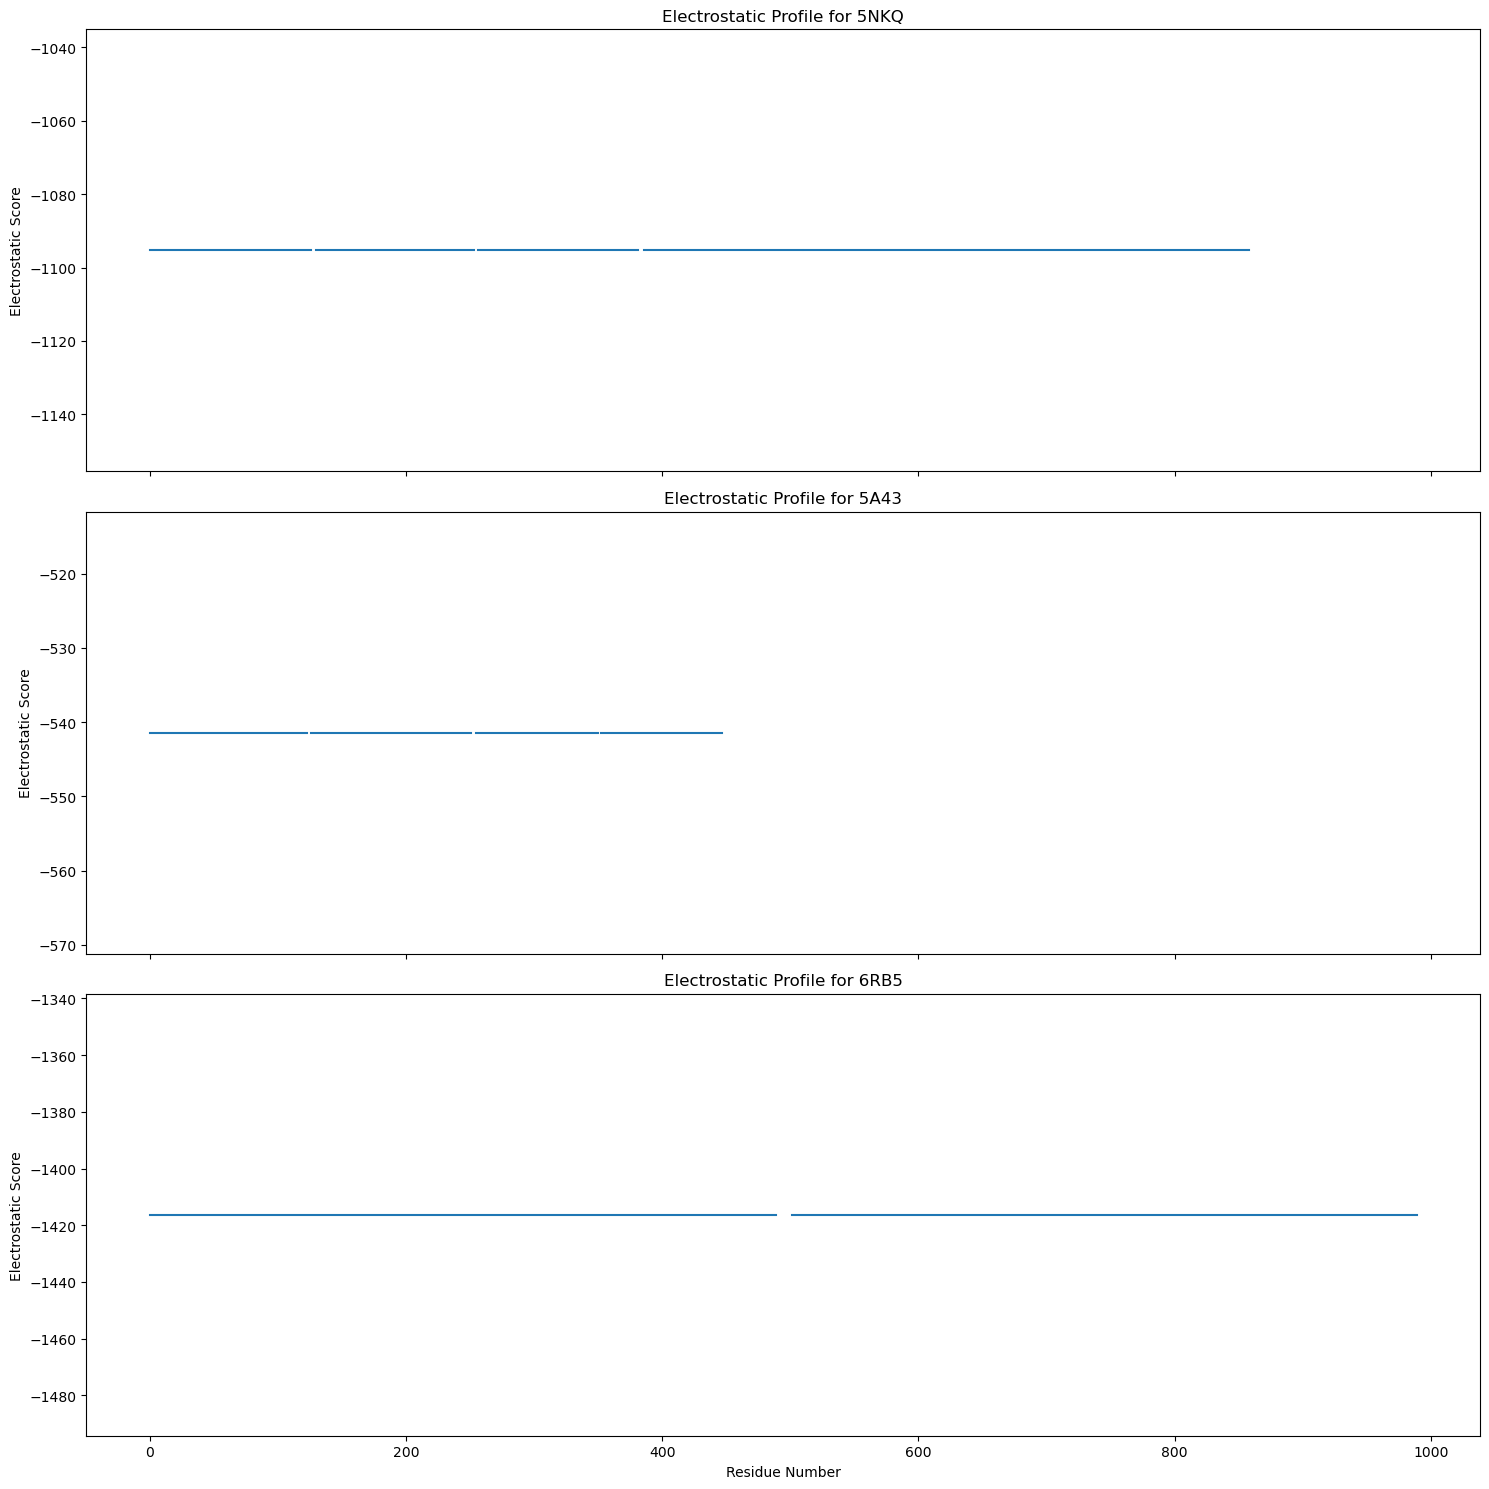

In [27]:
# Cell 13: Electrostatic Analysis
def plot_electrostatics(results):
    fig, axes = plt.subplots(len(results), 1, figsize=(15, 5*len(results)), sharex=True)
    for i, (pdb_id, data) in enumerate(results.items()):
        axes[i].plot(data['electrostatics'])
        axes[i].set_title(f'Electrostatic Profile for {pdb_id}')
        axes[i].set_ylabel('Electrostatic Score')
    axes[-1].set_xlabel('Residue Number')
    plt.tight_layout()
    plt.show()

plot_electrostatics(results)


In [28]:
# Cell 12: Functional Analysis (placeholder - requires external database)
def functional_analysis(key_residues):
    # This is a placeholder function. In practice, you would query a database like UniProt
    # or use a tool like InterProScan to get functional annotations for these residues.
    print("Functional analysis would go here. You would typically:")
    print("1. Query a protein database with your sequence")
    print("2. Map your key residues to known functional sites")
    print("3. Report any matches between key residues and known functional residues")

for pdb_id, data in results.items():
    print(f"\nFunctional analysis for {pdb_id}:")
    functional_analysis(data['key_residues'])



Functional analysis for 5NKQ:
Functional analysis would go here. You would typically:
1. Query a protein database with your sequence
2. Map your key residues to known functional sites
3. Report any matches between key residues and known functional residues

Functional analysis for 5A43:
Functional analysis would go here. You would typically:
1. Query a protein database with your sequence
2. Map your key residues to known functional sites
3. Report any matches between key residues and known functional residues

Functional analysis for 6RB5:
Functional analysis would go here. You would typically:
1. Query a protein database with your sequence
2. Map your key residues to known functional sites
3. Report any matches between key residues and known functional residues


In [29]:
# Cell 13: Ligand Docking (placeholder - requires docking software)
def ligand_docking(pdb_file, binding_sites):
    # This is a placeholder function. In practice, you would use a docking software
    # like AutoDock Vina or GOLD to perform the docking simulation.
    print("Ligand docking would go here. You would typically:")
    print("1. Prepare the protein structure")
    print("2. Prepare the ligand structure")
    print("3. Define the docking box around each binding site")
    print("4. Run the docking simulation")
    print("5. Analyze the docking results")

for pdb_id, data in results.items():
    pdb_file = f"./pdb/pdb{pdb_id.lower()}.ent"
    print(f"\nLigand docking for {pdb_id}:")
    ligand_docking(pdb_file, data['binding_sites'])



Ligand docking for 5NKQ:
Ligand docking would go here. You would typically:
1. Prepare the protein structure
2. Prepare the ligand structure
3. Define the docking box around each binding site
4. Run the docking simulation
5. Analyze the docking results

Ligand docking for 5A43:
Ligand docking would go here. You would typically:
1. Prepare the protein structure
2. Prepare the ligand structure
3. Define the docking box around each binding site
4. Run the docking simulation
5. Analyze the docking results

Ligand docking for 6RB5:
Ligand docking would go here. You would typically:
1. Prepare the protein structure
2. Prepare the ligand structure
3. Define the docking box around each binding site
4. Run the docking simulation
5. Analyze the docking results
